In [1]:
import warnings
warnings.filterwarnings('ignore')

# numerical libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# divide train and test (preproc)
from sklearn.cross_validation import train_test_split

# import different models
from sklearn.ensemble import RandomForestClassifier

# feature optimisation
from sklearn.feature_selection import SelectFromModel

# model optimisation
from sklearn.grid_search import RandomizedSearchCV

# model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation

# standarisation of features
from sklearn import preprocessing

In [2]:
cd Dropbox/Portfolio/DataScience-Portfolio/Titanic

/Users/Capgemini/Dropbox/Portfolio/DataScience-Portfolio/Titanic


In [4]:
# load data and test set
titanic = pd.read_csv('titanic_train_ready2.csv')

# generate X and Y for preditions
Y = np.ravel(titanic.Survived)  # to flatten array
X = titanic.drop('Survived', axis = 1)

In [5]:
# separate train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=1)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((623, 7), (268, 7), (623,), (268,))

In [6]:
# baseline accuracy (predicting that it did not survive)
baseline = round(1-np.mean(Y), 2)
baseline

0.62

### First Random Forest

In [7]:
# Random Forests Model
rf_model = RandomForestClassifier(n_estimators = 500, random_state = 1)
rf_model.fit(X_train, Y_train)
predicted = rf_model.predict(X_test)
metrics.accuracy_score(Y_test, predicted) 

0.7574626865671642

### Feature Scaling

In [8]:
def standarisation(train, test):
    scaler = preprocessing.StandardScaler().fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    return train, test

In [9]:
X_train_std, X_test_std = standarisation(X_train, X_test)

In [10]:
# Random Forests Model Std features
rf_model_std = RandomForestClassifier(n_estimators = 500, random_state = 1)
rf_model_std.fit(X_train_std, Y_train)
predicted = rf_model_std.predict(X_test_std)
metrics.accuracy_score(Y_test, predicted) 

0.7574626865671642

### Recursive feature elimination

In [11]:
# Recursive Feature Selection (RFS)
rf_RFS = SelectFromModel(rf_model, prefit=True)
X_train_RFS = rf_RFS.transform(X_train)
X_train_RFS.shape

(623, 3)

In [12]:
# which features were selected?
non_removedFeatures = rf_RFS.inverse_transform(X_train_RFS)
non_removedFeatures = non_removedFeatures.sum(axis = 0)
non_removedFeatures[non_removedFeatures > 0 ] = 1

# make a dataframe with the features and whether they were selected (1)
coef_df = pd.DataFrame(X.columns)
coef_df.columns = ['Features']

coef_df['Coefficients'] = pd.Series(non_removedFeatures)
coef_df

,Features,Coefficients
0,Pclass,0
1,Sex,1
2,Age,1
3,SibSp,0
4,Parch,0
5,Fare,1
6,Embarked,0


In [13]:
# select same features in test set
X_test_RFS = rf_RFS.transform(X_test)
X_test_RFS.shape

(268, 3)

In [14]:
# re fit the logistic regression with the 2 features only
rf_RFS = RandomForestClassifier()
rf_RFS.fit(X_train_RFS, Y_train)

predicted = rf_RFS.predict(X_test_RFS)  # predict affairs on test set
metrics.accuracy_score(Y_test,predicted)    # check accuracy

0.74626865671641796

### Adjust number of trees

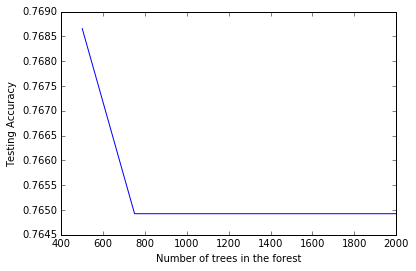

In [15]:
trees = list(range(500,2001,250))
accuracy = []
for tree in trees:
    rf_model = RandomForestClassifier(n_estimators = tree, random_state = 100)
    rf_model.fit(X_train, Y_train)
    predicted = rf_model.predict(X_test)
    accuracy.append(metrics.accuracy_score(Y_test, predicted))
    
plt.plot(trees, accuracy)
plt.xlabel('Number of trees in the forest')
plt.ylabel('Testing Accuracy')

The optimal number of trees is above 1000 (either 1250 or 1500)

### Adjust max features
The number of features to considered when looking for the best spli

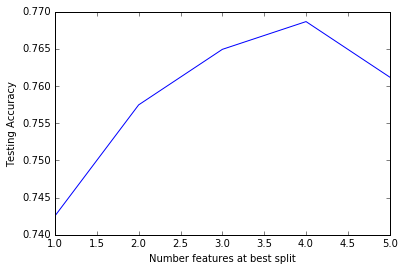

In [16]:
# auto is sqrt(n_features)
# Breinman suggest to start with half and go up to double
# auto here is sqrt(7) = 2

mtry = list(range(1,6,1))
accuracy = []
for mtr in mtry:
    rf_model = RandomForestClassifier(n_estimators = 1000, max_features = mtr, random_state = 1000)
    rf_model.fit(X_train, Y_train)
    predicted = rf_model.predict(X_test)
    accuracy.append(metrics.accuracy_score(Y_test, predicted))
    
plt.plot(mtry, accuracy)
plt.xlabel('Number features at best split')
plt.ylabel('Testing Accuracy')

I think the maximun number of features that works best is 4

In [17]:
# Random Forests Model
rf_model = RandomForestClassifier(n_estimators = 1250, max_features = 4, random_state = 1)
rf_model.fit(X_train, Y_train)
predicted = rf_model.predict(X_test)
metrics.accuracy_score(Y_test, predicted) 

0.76865671641791045

In [18]:
# Random Forests Model
rf_model = RandomForestClassifier(n_estimators = 1250, max_features = 4, criterion = 'entropy', random_state = 1)
rf_model.fit(X_train, Y_train)
predicted = rf_model.predict(X_test)
metrics.accuracy_score(Y_test, predicted)

0.77238805970149249

**At the minute the above model is the best one**

In [19]:
# below the parameters that can be optimized using sklearn package
rf_model.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 4,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1250,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [20]:
# Utility function to report best scores ==>> taken from sklearn documentation
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [21]:
from scipy.stats import randint as sp_randint
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 7),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

In [22]:
clf = RandomForestClassifier(n_estimators=100)

In [23]:
# run randomized search
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter = 20)

In [24]:
# fit the model
random_search.fit(X_train, Y_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=20, n_jobs=1,
          param_distributions={'bootstrap': [True, False], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10ec45f28>, 'criterion': ['gini', 'entropy'], 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10ec3b160>, 'max_depth': [3, None], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x10ec45d68>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [25]:
from operator import itemgetter
report(random_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.831 (std: 0.011)
Parameters: {'bootstrap': False, 'min_samples_split': 2, 'criterion': 'gini', 'min_samples_leaf': 10, 'max_depth': None, 'max_features': 6}

Model with rank: 2
Mean validation score: 0.830 (std: 0.014)
Parameters: {'bootstrap': False, 'min_samples_split': 10, 'criterion': 'entropy', 'min_samples_leaf': 9, 'max_depth': None, 'max_features': 2}

Model with rank: 3
Mean validation score: 0.830 (std: 0.015)
Parameters: {'bootstrap': False, 'min_samples_split': 7, 'criterion': 'gini', 'min_samples_leaf': 8, 'max_depth': None, 'max_features': 6}



In [26]:
predicted = random_search.predict(X_test)
metrics.accuracy_score(Y_test, predicted)

0.77985074626865669

In [30]:
# Random Forests Model
rf_model = RandomForestClassifier(n_estimators = 1250, max_features = 6, criterion = 'gini', bootstrap = False,
                                  min_samples_split = 2, min_samples_leaf = 10, max_depth = None,
                                  random_state = 1)
rf_model.fit(X_train, Y_train)
predicted = rf_model.predict(X_test)
metrics.accuracy_score(Y_test, predicted)

0.77611940298507465

In [32]:
# Scaling doesn't make any difference
rf_model = RandomForestClassifier(n_estimators = 1250, max_features = 6, criterion = 'gini', bootstrap = False,
                                  min_samples_split = 2, min_samples_leaf = 10, max_depth = None,
                                  random_state = 1)
rf_model.fit(X_train_std, Y_train)
predicted = rf_model.predict(X_test_std)
metrics.accuracy_score(Y_test, predicted)

0.77611940298507465

### Prepare for submission

In [33]:
rf_model = RandomForestClassifier(n_estimators = 1250, max_features = 6, criterion = 'gini', bootstrap = False,
                                  min_samples_split = 2, min_samples_leaf = 10, max_depth = None,
                                  random_state = 1)
rf_model.fit(X, Y)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1250, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [34]:
titanic_test = pd.read_csv('titanic_test_ready2.csv')
predicted = rf_model.predict(titanic_test)

In [35]:
test_df = pd.read_csv('test.csv')

submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": predicted
    })

submission.to_csv('titanic_submission_rf.csv', index=False)